To-Do's
* Need to fix and create a no-no untouchable list of stocks since my != of GME is not working. ["GME", "BRK.B", "META"]
* Need to Fix Sortino Ratio its prining out a rediculous one. 
* Need to Plot Historical Returns with Data Against the S&P 500. 

In [297]:
import pandas as pd
import numpy as np 
import scipy as sp
import statsmodels.formula.api as smf
import scipy.optimize as sco
from fredapi import Fred
from tickers_list import tickers
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_rows', 10)
plt.style.use('fivethirtyeight')
%matplotlib inline

Here we are cleaning the overall stock data from factset. 
- The problem we are having is that factset's numbers are not in a floating point number format (AKA Decimal). So we had to srip out the commas in the data set to convert into a float number. 

In [298]:
# stock_data = pd.read_csv("Factset_Screen_Data\stock_data.csv") # Initial data import from Factset
stock_data = pd.read_csv("Factset_Screen_Data\S_P_smoked.csv")

# Rename columns Symbol to Ticker
stock_data.rename(columns={'Symbol':'Ticker'}, inplace=True)
# Make Ticker the index
stock_data.set_index('Ticker', inplace=True)
# Remove commas in Recent Closing Price, Market Value, Purchase Price, Common Shares Columns, There is something wrong with lookback closing price.

# stock_data['Lookback Closing Price'] = stock_data['Lookback Closing Price'].str.replace(',', '').astype(float) # I Guess there are no floats in this column.
stock_data['Purchase Closing Price'] = stock_data['Purchase Closing Price'].str.replace(',', '').astype(float)
stock_data['Recent Closing Price'] = stock_data['Recent Closing Price'].str.replace(',', '').astype(float)
stock_data['Current Market Value'] = stock_data['Current Market Value'].str.replace(',', '').astype(float)
stock_data['Look Back Common Shares'] = stock_data['Look Back Common Shares'].str.replace(',', '').astype(float)
stock_data['Purchase Price Common Shares'] = stock_data['Purchase Price Common Shares'].str.replace(',', '').astype(float)
stock_data['Current Common Shares'] = stock_data['Current Common Shares'].str.replace(',', '').astype(float)

bad_tickers = ["BF.B", "BRK.B", "LGF.A", "MOG.A"]
stock_data = stock_data.drop(bad_tickers, axis=0) # Drop bad tickers


stock_data.head(26)

,Name,Stock Exchange,RBICS Economy,Lookback Closing Price,Purchase Closing Price,Recent Closing Price,Current Market Value,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares
Ticker,,,,,,,,,,
A,"Agilent Technologies, Inc.",NYSE,Healthcare,42.5,40.9,136.5,40761.8,348.1,335.3,296.0
AA,Alcoa Corporation,NYSE,Non-Energy Materials,91.4,142.1,41.4,7673.8,118.3,135.2,176.9
AAON,"AAON, Inc.",NASDAQ,Industrials,9.0,22.4,63.1,3256.4,55.4,54.5,53.1
AAP,"Advance Auto Parts, Inc.",NYSE,Consumer Cyclicals,76.6,159.3,188.1,10930.1,72.4,73.0,60.1
AAPL,Apple Inc.,NASDAQ,Technology,16.3,27.6,144.8,2400167.0,26106.4,23459.4,16070.8
...,...,...,...,...,...,...,...,...,...,...
ADC,Agree Realty Corporation,NYSE,Finance,25.0,31.1,67.3,5329.7,11.2,17.5,79.8
ADEA,Adeia Inc.,NASDAQ,Consumer Services,19.8,35.8,10.7,1111.5,51.5,52.8,104.3
ADI,"Analog Devices, Inc.",NASDAQ,Technology,39.1,55.5,140.7,72717.6,298.0,311.2,514.3


The problem we are having is to try to get time series data in Factset of the individual stocks since we wanted to apply modern portfolio theory to our allocation. Here are some problems we ran into. 
* Factset does not have time series data for a list of stocks. 
* Yfinance has a rate limiter which is extreamly slow. In perspective it would take over 30 mins to get all data for the ticker list each call!
* Quandl for NASDAQ is not working properly. 
* But Wharton WRDS was our best option without paying for an API key from Alpha Vantage, Morning Start, ect. 

In [299]:

df1 = pd.read_csv("Wrds_Data\wrds_smoked_raw.csv")
df2 = df1.pivot_table(index='MthCalDt', columns="Ticker", values="MthPrc", aggfunc='first')
remove_strings_df = df2.apply(lambda x: x.str.replace(',','')) # Brute Force way to remove strings. 

remove_strings_df

Ticker,A,AA,AAON,AAP,AAPL,AAT,AAWW,AB,ABC,ABCB,...,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZD,ZION
MthCalDt,,,,,,,,,,,,,,,,,,,,,
20120131,42.47,NaN,20.22,76.64,456.48,22.14,47.635,15.22,38.97,10.7,...,83.74,11.474,37.74,7.75,25.91,63.33,60.75,37.84,26.96,16.83
20120229,43.62,NaN,18.55,85.37,542.44,21.52,42.62,14,37.37,11.52,...,86.5,16.77,38.71,8.23,25.98,66.24,60.75,38.44,29.61,19
20120330,44.51,NaN,20.19,88.57,599.55,22.8,49.21,15.61,39.66,13.14,...,86.73,16.8,40.13,8.075,27.75,71.18,64.28,41.18,28.68,21.46
20120430,42.18,NaN,20.4,91.8,583.98,23.51,46.05,14.09,37.21,12.4,...,86.34,16.61,41.06,7.78,27.88,72.73,62.93,38.79,25.83,20.39
20120531,40.66,NaN,18.74,72.94,577.73,22.59,45.42,12.9,36.99,11.37,...,78.63,17.86,37,7.22,25.33,70.36,60.65,33.47,24.19,19.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211130,150.9,46.53,78,220.72,165.3,34.4,87.61,50.12,115.75,48.67,...,59.84,72.44,48.74,18.42,121.11,122.84,119.6,588.78,113.87,63.08
20211231,159.65,59.58,79.43,239.88,177.57,37.53,94.12,48.84,132.89,49.68,...,61.19,77.43,55.79,22.64,119.92,138.86,127.04,595.2,110.86,63.16
20220131,139.32,56.71,64.25,231.51,174.78,35.97,80.33,46.95,136.2,49.31,...,75.96,66.17,53.42,21.11,105.02,125.17,123.02,509.12,105.06,67.82


Here we are converting the cleaned data from a string into a float. The problem that I was having is that the Data had commas in the numbers where pandas was reading it. '1,560.09'

* pt_ret is the arthematic returns of the stocks
* pt_log is the natural log returns of the stocks. (Harmonic)

In [300]:
cleaned_data = remove_strings_df.astype(float)
pt_ret = cleaned_data.pct_change(1)[1:]
pt_log = np.log(cleaned_data/cleaned_data.shift(1))[1:]
pt_log

Ticker,A,AA,AAON,AAP,AAPL,AAT,AAWW,AB,ABC,ABCB,...,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZD,ZION
MthCalDt,,,,,,,,,,,,,,,,,,,,,
20120229,0.026718,NaN,-0.086202,0.107876,0.172533,-0.028403,-0.111244,-0.083553,-0.041924,0.073841,...,0.032428,0.379508,0.025377,0.060093,0.002698,0.044925,0.000000,0.015732,0.093758,0.121276
20120330,0.020198,NaN,0.084718,0.036798,0.100102,0.057778,0.143773,0.108854,0.059475,0.131576,...,0.002655,0.001787,0.036026,-0.019013,0.065909,0.071927,0.056481,0.068854,-0.031912,0.121752
20120430,-0.053768,NaN,0.010347,0.035819,-0.026313,0.030665,-0.066369,-0.102446,-0.063766,-0.057965,...,-0.004507,-0.011374,0.022910,-0.037217,0.004674,0.021542,-0.021226,-0.059790,-0.104663,-0.051146
20120531,-0.036701,NaN,-0.084875,-0.229975,-0.010760,-0.039919,-0.013775,-0.088238,-0.005930,-0.086718,...,-0.093540,0.072559,-0.104116,-0.074701,-0.095920,-0.033129,-0.036903,-0.147513,-0.065597,-0.069028
20120629,-0.035548,NaN,0.005853,-0.066899,0.010794,0.070909,-0.042962,-0.016413,0.061848,0.102719,...,0.084581,-0.061185,0.021656,0.086203,-0.006337,-0.088201,0.059373,0.026244,0.088182,0.020287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211130,-0.042745,0.012543,0.084916,-0.021514,0.098461,-0.095046,0.076966,-0.117872,-0.052752,-0.073653,...,-0.074526,-0.169260,-0.160229,0.034239,-0.075363,-0.016951,-0.179531,0.097750,-0.119080,0.001428
20211231,0.056367,0.247223,0.018167,0.083244,0.071603,0.087084,0.071675,-0.025870,0.138089,0.020540,...,0.022309,0.066616,0.135095,0.206281,-0.009874,0.122584,0.060349,0.010845,-0.026789,0.001267
20220131,-0.136210,-0.049369,-0.212094,-0.035516,-0.015837,-0.042455,-0.158427,-0.039466,0.024603,-0.007476,...,0.216223,-0.157147,-0.043409,-0.069971,-0.132674,-0.103793,-0.032155,-0.156214,-0.053737,0.071186


Here we are adding market data and damodarans ERP for the stocks since we want a forward looking return to continue to beat the S&P500
* The Risk Free Rate is the 10yr US Treasury Note 
* Equity Risk Premium is the recent damodarn ERP. 

In [301]:
risk_free_rate = 0.0420 # 10 year treasury rate as of 10/23/2022 at 7:09pm (From Bloomberg)
equity_risk_premium = 0.0530 # Damodaran's estimate for October 2022
arth_Sigma = pt_ret.cov() # Covariance Martrix of the arthmatic returns
log_Sigma = pt_log.cov() # Covariance Matrix of the log returns


arth_pt_var = pt_ret.var()*12 # Variance of the arthmatic returns
log_pt_var = pt_log.var()*12 # Variance of the log returns


arth_pt_dvar = pt_ret[pt_ret < 0].var()*12 # Downside Variance of the arthmatic returns
log_pt_dvar = pt_log[pt_log < 0].var()*12 # Downside Variance of the log returns



log_Sigma

Ticker,A,AA,AAON,AAP,AAPL,AAT,AAWW,AB,ABC,ABCB,...,XOM,XPO,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZD,ZION
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.004339,0.004679,0.001775,0.001107,0.001109,0.000916,0.001978,0.002086,0.000858,0.001864,...,0.001141,0.002633,0.001615,0.002327,0.002230,0.001438,0.002039,0.002844,0.001276,0.002066
AA,0.004679,0.035252,0.001429,0.008541,0.002489,0.011030,0.011121,0.009754,0.002420,0.010848,...,0.009305,0.011429,0.005342,0.011974,0.004312,0.006324,0.008008,0.007153,0.004544,0.012111
AAON,0.001775,0.001429,0.009368,0.001456,-0.000063,0.000987,0.002642,0.001636,0.000530,0.001031,...,0.000496,0.000824,0.001360,0.001950,0.002884,0.001449,0.001121,0.002982,0.000876,0.001709
AAP,0.001107,0.008541,0.001456,0.007829,-0.000085,0.003120,0.001937,0.003119,0.001130,0.002871,...,0.002754,0.003300,0.002006,0.000785,0.002186,0.001607,0.002041,0.003238,0.001918,0.003002
AAPL,0.001109,0.002489,-0.000063,-0.000085,0.048291,0.001697,0.001542,0.001062,0.001299,0.000641,...,0.001642,0.000445,0.000719,0.000435,-0.000060,0.000719,0.001195,0.002010,-0.002341,0.001259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.001438,0.006324,0.001449,0.001607,0.000719,0.001831,0.000752,0.002383,0.000435,0.001105,...,0.001264,0.003248,0.001629,0.002864,0.001828,0.005131,0.001993,0.002189,0.000973,0.001640
ZBH,0.002039,0.008008,0.001121,0.002041,0.001195,0.002482,0.001830,0.003251,0.001383,0.002678,...,0.002469,0.004615,0.002461,0.004013,0.002133,0.001993,0.004856,0.002175,0.001756,0.002529
ZBRA,0.002844,0.007153,0.002982,0.003238,0.002010,0.002351,0.002571,0.003497,0.001392,0.003900,...,0.002467,0.005832,0.001076,0.003530,0.003103,0.002189,0.002175,0.009579,0.002372,0.004246


Here is our regression to get the beta and alpha on each stock.

In [302]:
total_data = pd.DataFrame()
for column in pt_log:
    model = smf.ols(f'{column} ~ IVV', data=pt_log).fit()
    beta = model.params['IVV']
    alpha = model.params['Intercept']
    stderrA = model.bse['Intercept']
    stderrB = model.bse['IVV']
    rsquared = model.rsquared
    stats_data = pd.DataFrame({'Beta': [beta], 'Alpha': [alpha], 'StdErrA': [stderrA], 'StdErrB': [stderrB], 'R-squared':[rsquared]}, index=[column])
    total_data = pd.concat([total_data, stats_data])

total_data.index = total_data.index.rename('Ticker')
capm = ((risk_free_rate + total_data['Beta']) * equity_risk_premium)
adjCapm = ((risk_free_rate + total_data['Beta'] + total_data['Alpha']) * equity_risk_premium)
sharpe_ratio_arth = ((risk_free_rate + capm)/np.sqrt(arth_pt_var))
sharpe_ratio_log = ((risk_free_rate + capm)/np.sqrt(log_pt_var))
sortino_ratio_arth = ((risk_free_rate + capm)/np.sqrt(arth_pt_dvar))
sortino_ratio_log = ((risk_free_rate + capm)/np.sqrt(log_pt_dvar))
total_data['CAPM'] = capm
total_data['AdjCAPM'] = adjCapm
total_data['Sharpe Ratio (Arth)'] = sharpe_ratio_arth
total_data['Sharpe Ratio (Log)'] = sharpe_ratio_log
total_data['Sortino Ratio (Arth)'] = sortino_ratio_arth
total_data['Sortino Ratio (Log)'] = sortino_ratio_log

total_data = total_data.join(stock_data[['Purchase Closing Price', 'Recent Closing Price', 'Look Back Common Shares', 
                                         'Purchase Price Common Shares', 'Current Common Shares', 'Current Market Value']]) # Join the stock data to the total data
total_data = total_data[(total_data['Alpha'] > 0) & (total_data['Beta'] < 3) & (total_data['AdjCAPM'] > risk_free_rate)]
total_data

,Beta,Alpha,StdErrA,StdErrB,R-squared,CAPM,AdjCAPM,Sharpe Ratio (Arth),Sharpe Ratio (Log),Sortino Ratio (Arth),Sortino Ratio (Log),Purchase Closing Price,Recent Closing Price,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares,Current Market Value
Ticker,,,,,,,,,,,,,,,,,
ABG,1.432745,0.001422,0.008413,0.212765,0.274248,0.078162,0.078237,0.336877,0.330374,0.484372,0.400905,75.9,158.0,31.8,29.8,22.1,3421.8
ABMD,1.056604,0.012940,0.011093,0.280552,0.105705,0.058226,0.058912,0.231474,0.231982,0.376353,0.320701,38.1,267.6,38.6,40.9,45.5,12194.9
ACHC,1.338960,0.000177,0.010156,0.256845,0.184653,0.073191,0.073200,0.287421,0.278078,0.409377,0.337650,61.2,82.3,32.1,59.9,90.8,7417.2
ACLS,1.663578,0.013770,0.015312,0.387261,0.133283,0.090396,0.091125,0.129557,0.218552,0.517000,0.446215,10.2,57.3,26.6,28.0,33.0,1937.4
ACN,1.200647,0.002355,0.003553,0.089854,0.598055,0.065860,0.065985,0.521670,0.522582,0.785703,0.730568,89.3,278.8,640.9,628.1,664.8,186052.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WST,0.901438,0.009857,0.007416,0.187544,0.161442,0.050002,0.050525,0.332860,0.308466,0.359390,0.279928,53.2,221.2,67.4,71.1,74.0,18837.8
WTS,1.020438,0.000206,0.004896,0.123835,0.361372,0.056309,0.056320,0.436632,0.435635,0.653330,0.598520,63.4,138.9,29.4,28.7,27.3,4577.0
WWE,1.091841,0.004378,0.011796,0.298322,0.100417,0.060094,0.060326,0.224853,0.222885,0.316351,0.259241,12.3,78.4,28.1,33.2,43.3,5865.3


Now Here is our Stats Screen where 
1. Purchase Price has to be greater than the Recent Closing Price  
2. Take the 100 Largest Soritno Stocks with positive alpha only and pair them to the least correlated stock.
3. Take the 100 Largest Market Cap Stocks and pair them with the least correlated stocks in the data. 


In [303]:
# Here is the Correlation of Returns
correlation_of_arth_returns = pt_ret.corr() # Correlation Matrix of the arthmatic returns
correlation_of_log_returns = pt_log.corr() # Correlation Matrix of the log returns


# Purchase Price has to be less than recent closing price, Alpha Greater than 0 
data_screen = total_data[total_data['Purchase Closing Price'] < total_data['Recent Closing Price']]


# Here we are getting the larget sortino ratio stocks 
largest_arth_sortino = data_screen.nlargest(100, 'Sortino Ratio (Arth)')
largest_log_sortino = data_screen.nlargest(100, 'Sortino Ratio (Log)')


largest_sortino = largest_log_sortino.head(100)

# Here we are getting the list of the larget sortino ratio stocks
tickers_list_of_largest_sortino = largest_sortino.index.tolist()


lowest_correlation = pd.DataFrame()
for ticker in tickers_list_of_largest_sortino:
    lowest_correlation = pd.concat([lowest_correlation,
     pd.DataFrame({'Ticker': [ticker], 'Paired Tickers': [correlation_of_log_returns[ticker].nsmallest(2).index[1]],
     'Correlation': [correlation_of_log_returns[ticker].nsmallest(2)[1]]})])
large_sortino_lowest_correlation = lowest_correlation
average_correlation = lowest_correlation['Correlation'].mean()


lowest_correlation.head(10)


,Ticker,Paired Tickers,Correlation
0,ROP,GME,-0.087748
0,ITW,CALM,-0.060768
0,SNPS,DAC,-0.049767
0,IEX,CSR,-0.042668
0,JBHT,DHT,-0.106430
0,PLD,GLNG,-0.094946
0,TXN,DHT,-0.112355
0,SYK,CSR,-0.070949
0,MSFT,BPOP,-0.078159
0,FR,CRK,-0.063327


Here we are taking the top 100 Market Cap Stocks in the NASDAQ & NSYE. 

In [304]:
# Top 50 Largest Market Cap Stocks
largest_market_cap = stock_data.nlargest(100, 'Current Market Value')
largest_market_cap = largest_market_cap[largest_market_cap['Purchase Closing Price'] < largest_market_cap['Recent Closing Price']]
# Remove BRK.B from the list of largest_market_cap
largest_market_cap = largest_market_cap[largest_market_cap.index != 'BRK.B']

ticker_list_of_largest_market_cap = largest_market_cap.index.tolist()
largest_market_cap

,Name,Stock Exchange,RBICS Economy,Lookback Closing Price,Purchase Closing Price,Recent Closing Price,Current Market Value,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares
Ticker,,,,,,,,,,
AAPL,Apple Inc.,NASDAQ,Technology,16.3,27.6,144.8,2400167.0,26106.4,23459.4,16070.8
MSFT,Microsoft Corporation,NASDAQ,Technology,29.5,46.5,226.8,1724369.0,8390.8,8242.9,7454.5
GOOGL,Alphabet Inc. Class A,NASDAQ,Technology,14.5,26.5,92.2,1228010.0,10308.5,5696.3,5973.0
AMZN,"Amazon.com, Inc.",NASDAQ,Consumer Non-Cyclicals,9.7,15.5,111.0,1178293.0,9095.1,9260.1,10187.6
UNH,UnitedHealth Group Incorporated,NYSE,Healthcare,51.8,101.1,541.8,508071.8,1066.0,959.8,935.4
...,...,...,...,...,...,...,...,...,...,...
ADI,"Analog Devices, Inc.",NASDAQ,Technology,39.1,55.5,140.7,72717.6,298.0,311.2,514.3
PGR,Progressive Corporation,NYSE,Finance,20.3,27.0,124.4,71889.5,613.7,587.8,584.8
SO,Southern Company,NYSE,Utilities,45.6,49.1,65.2,71432.6,861.9,899.8,1088.7


Now We are Getting the Largest Market Cap Stocks and pairing it with the least negative in our overall initial screen. 

In [305]:
lowest_correlation = pd.DataFrame()
for ticker in ticker_list_of_largest_market_cap:
    lowest_correlation = pd.concat([lowest_correlation,
     pd.DataFrame({'Ticker': [ticker], 'Paired Tickers': [correlation_of_log_returns[ticker].nsmallest(2).index[1]],
     'Correlation': [correlation_of_log_returns[ticker].nsmallest(2)[1]]})])
large_mkcap_lowest_correlation = lowest_correlation
average_correlation = lowest_correlation['Correlation'].mean()
large_mkcap_lowest_correlation.head(100)


,Ticker,Paired Tickers,Correlation
0,AAPL,CPE,-0.238923
0,MSFT,BPOP,-0.078159
0,GOOGL,NI,-0.113474
0,AMZN,NI,-0.172911
0,UNH,DUK,-0.153656
...,...,...,...
0,ADI,ED,-0.092122
0,PGR,GME,-0.126364
0,SO,STAA,-0.173912
0,DUK,MATX,-0.576828


Here we are concatinating both datasets with the Highest Sortino and Highest Makret Cap.
If there aare Stocks are in both datasets, then we are droping them so they are not repeated. 

In [306]:
# Concatenate large_sortino_lowest_correlation and large_mkcap_lowest_correlation using pd.concat and remove duplicates. 
concat_tickers = pd.concat([large_sortino_lowest_correlation, large_mkcap_lowest_correlation], ignore_index=False).drop_duplicates()
# Set index to Ticker
concat_tickers = concat_tickers.set_index('Ticker')
# Drop GME from the list of concat_tickers in the paired tickers column
cleaned_ticker_list = concat_tickers[concat_tickers['Paired Tickers'] != 'GME']
total_average_correlation = cleaned_ticker_list['Correlation'].mean()
print(f'The Average Total Correlation: {total_average_correlation} \n')
print(cleaned_ticker_list.head(10))

# Create a list of the tickers in concat_tickers from both the Ticker and Paired Tickers columns
total_ticker_list = concat_tickers.index.tolist() + concat_tickers['Paired Tickers'].tolist()

# Filter total_data to only include the tickers in total_ticker_list
filtered_total_data = total_data[total_data.index.isin(total_ticker_list)]
print(f'Total Stocks: {filtered_total_data.shape[0]} \n')
filtered_total_data


The Average Total Correlation: -0.12826566852396756 

       Paired Tickers  Correlation
Ticker                            
ITW              CALM    -0.060768
SNPS              DAC    -0.049767
IEX               CSR    -0.042668
JBHT              DHT    -0.106430
PLD              GLNG    -0.094946
TXN               DHT    -0.112355
SYK               CSR    -0.070949
MSFT             BPOP    -0.078159
FR                CRK    -0.063327
MDT              QDEL    -0.133309
Total Stocks: 113 



,Beta,Alpha,StdErrA,StdErrB,R-squared,CAPM,AdjCAPM,Sharpe Ratio (Arth),Sharpe Ratio (Log),Sortino Ratio (Arth),Sortino Ratio (Log),Purchase Closing Price,Recent Closing Price,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares,Current Market Value
Ticker,,,,,,,,,,,,,,,,,
ACN,1.200647,0.002355,0.003553,0.089854,0.598055,0.065860,0.065985,0.521670,0.522582,0.785703,0.730568,89.3,278.8,640.9,628.1,664.8,186052.9
ADBE,1.008978,0.011818,0.004862,0.122955,0.359452,0.055702,0.056328,0.430103,0.436696,0.818266,0.759172,72.7,318.7,493.8,498.7,464.9,148991.2
ADI,1.103598,0.000621,0.004725,0.119487,0.415507,0.060717,0.060750,0.445308,0.451292,0.787424,0.726832,55.5,140.7,298.0,311.2,514.3,72717.6
ADP,0.837729,0.003183,0.003789,0.095820,0.389111,0.046626,0.046794,0.495921,0.496399,0.684928,0.639548,83.4,235.0,488.7,482.1,415.3,97651.7
AEIS,1.423424,0.002711,0.007858,0.198733,0.299480,0.077667,0.077811,0.335871,0.346069,0.697218,0.637215,23.7,76.5,44.4,40.1,37.4,2840.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEX,1.950171,0.026014,0.039090,0.988625,0.031408,0.105585,0.106964,0.005339,0.100885,0.527327,0.422701,98.9,158.7,38.7,38.8,44.2,6540.9
WM,0.832985,0.003995,0.003184,0.080516,0.471438,0.046374,0.046586,0.546650,0.547946,0.769641,0.720967,51.3,158.3,460.3,457.9,410.5,65664.0
WSO,0.812701,0.004043,0.004880,0.123407,0.265467,0.045299,0.045513,0.405053,0.416315,0.652259,0.603207,107.0,262.7,28.4,30.1,33.2,10187.8


Here were are going to do the post modern portfolio theory where we are going to create an optimized portfolio with the highest sortino ratio.

In [307]:
expectedReturn = filtered_total_data['CAPM']
# Get the downside covariance matix  less than 0 from pt_log with the ticker in filtered total data
downside_covariance = pt_log[pt_log < 0]
Sigma = downside_covariance[filtered_total_data.index].cov()*12

# Here is the bound for the minimum and maximum weights for each stock.
min_weight = 0.001
max_weight = 0.08

# Here is the number of simulations of the stocks
num_port = 100000



def portfolio_annualised_performance(weights, expectedReturns, Sigma):
    returns = np.sum(expectedReturns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return std, returns

def neg_sharpe_ratio(weights, expectedReturns, Sigma, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, expectedReturns, Sigma)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(expectedReturns, Sigma, risk_free_rate):
    num_assets = len(expectedReturns)
    args = (expectedReturns, Sigma, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (min_weight,max_weight)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, expectedReturns, Sigma):
    return portfolio_annualised_performance(weights, expectedReturns, Sigma)[0]

def min_variance(expectedReturns, Sigma):
    num_assets = len(expectedReturns)
    args = (expectedReturns, Sigma)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (min_weight,max_weight)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result


def display_ef_with_selected(expectedReturns, Sigma, risk_free_rate):
    max_sharpe = max_sharpe_ratio(expectedReturns, Sigma, risk_free_rate)
    max_sharpe_allocation = pd.DataFrame({"+SharpeWeight":max_sharpe.x})

    min_vol = min_variance(expectedReturns, Sigma)
    min_vol_allocation = pd.DataFrame({'-VolWeight':min_vol.x})

    
    wWeight = np.zeros((num_port,len(expectedReturns)))
    expectedReturn = np.zeros(num_port)
    expectedVolatility = np.zeros(num_port)
    sharpeRatio = np.zeros(num_port)

    markowiz_dataframe = pd.DataFrame()
    for k in range(num_port):
        # Generate random weight vector
        w = np.array(np.random.random(len(expectedReturns)))
        w = w / np.sum(w)
        wWeight[k,:] = w
        expectedReturn[k] = np.sum((expectedReturns * w))
        expectedVolatility[k] = np.sqrt(np.dot(w.T,np.dot(Sigma, w)))
        sharpeRatio[k] = expectedReturn[k]/expectedVolatility[k]

    maxIndex = sharpeRatio.argmax()
    lmx = wWeight[maxIndex,:]
    bruteAllocation = pd.DataFrame({'bruteAllocation': lmx})


    # Concatenate the max_sharpe_allocation, min_vol_allocation, and bruteAllocation DataFrames
    markowiz_dataframe = pd.concat([max_sharpe_allocation, bruteAllocation], axis=1)

    # Concatenate the filtered_total_data and markowiz_dataframe DataFrames on the filtered_total_data index
    markowiz_dataframe = pd.concat([filtered_total_data.reset_index(), markowiz_dataframe],axis=1)
    markowiz_dataframe = markowiz_dataframe.set_index('Ticker')
    

    return markowiz_dataframe
    

efficent_frontier_data = display_ef_with_selected(expectedReturn, Sigma, risk_free_rate)



# Check to See if the Data sums to 1
print(f"To Check if Summed to One: {efficent_frontier_data[['+SharpeWeight']].sum().to_string()}")
print(f"To Check if Summed to One: {efficent_frontier_data[['bruteAllocation']].sum().to_string()} \n")


portfolio_expected_return_Scipy = np.sum(efficent_frontier_data['CAPM']*efficent_frontier_data['+SharpeWeight'])
portfolio_expected_return_brute = np.sum(efficent_frontier_data['CAPM']*efficent_frontier_data['bruteAllocation'])

portfolio_volatility_Scipy = np.sqrt(np.dot(efficent_frontier_data['+SharpeWeight'].T,np.dot(Sigma, efficent_frontier_data['+SharpeWeight'])))
portfolio_volatility_brute = np.sqrt(np.dot(efficent_frontier_data['bruteAllocation'].T,np.dot(Sigma, efficent_frontier_data['bruteAllocation'])))

portfolio_sortino_Scipy = ((portfolio_expected_return_brute - risk_free_rate)/portfolio_volatility_Scipy)
rounding_sortino_ratio = round(portfolio_sortino_Scipy, 2) 


print(f"Sortino Ratio: {rounding_sortino_ratio}")
print(f"Portfolio Expected Return Scipy: {portfolio_expected_return_Scipy}")
# print(f"Portfolio Sortino Ratio Scipy: {portfolio_expected_return_Scipy/portfolio_volatility_Scipy} /n")
print(f"Portfolio Expected Return Brute: {portfolio_expected_return_brute}")



# Sort by brite force allocation for the largest weights
sorted_brute_allocation = efficent_frontier_data.sort_values(by=['bruteAllocation'], ascending=False)
sorted_brute_allocation.to_csv('Output_Attribution/highest_sortino_stocks.csv')
sorted_brute_allocation

c:\Users\Trevor\Desktop\DevProj\University_Coding\Popova_Project\not_ltcm\env\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


To Check if Summed to One: +SharpeWeight    1.0
To Check if Summed to One: bruteAllocation    1.0 

Sortino Ratio: 0.2
Portfolio Expected Return Scipy: 0.06406616284072279
Portfolio Expected Return Brute: 0.05563784338626347


,Beta,Alpha,StdErrA,StdErrB,R-squared,CAPM,AdjCAPM,Sharpe Ratio (Arth),Sharpe Ratio (Log),Sortino Ratio (Arth),Sortino Ratio (Log),Purchase Closing Price,Recent Closing Price,Look Back Common Shares,Purchase Price Common Shares,Current Common Shares,Current Market Value,+SharpeWeight,bruteAllocation
Ticker,,,,,,,,,,,,,,,,,,,
BDX,0.750849,0.002404,0.004138,0.104659,0.300169,0.042021,0.042148,0.458893,0.461165,0.704694,0.659618,139.2,231.2,213.6,193.4,285.2,66416.2,0.001,0.018515
NNI,0.822260,0.001813,0.006319,0.159814,0.180732,0.045806,0.045902,0.331474,0.341483,0.692251,0.647126,46.3,87.6,35.6,34.8,26.5,3244.1,0.001,0.018222
PRI,1.323291,0.000688,0.005340,0.135065,0.444419,0.072360,0.072397,0.430330,0.433366,0.692026,0.629992,54.3,138.1,64.9,53.1,37.5,5168.5,0.001,0.018146
KLIC,1.267037,0.000645,0.008097,0.204772,0.241877,0.069379,0.069413,0.316233,0.325199,0.651551,0.594348,14.5,40.8,73.7,77.0,58.1,2446.4,0.080,0.017931
IEX,1.093248,0.001661,0.003344,0.084566,0.582067,0.060168,0.060256,0.534385,0.536316,0.884341,0.829670,77.8,217.5,83.4,79.4,75.4,16579.8,0.001,0.017359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AON,0.953773,0.005954,0.003890,0.098369,0.439278,0.052776,0.053092,0.497199,0.495405,0.691561,0.632116,94.8,282.3,323.3,285.1,210.9,58453.8,0.001,0.000189
ENTG,1.183176,0.009465,0.006582,0.166454,0.296292,0.064934,0.065436,0.362482,0.370055,0.660606,0.608206,13.2,78.8,135.1,139.5,149.0,11957.4,0.001,0.000141
FDS,0.796687,0.004979,0.004484,0.113397,0.291449,0.044450,0.044714,0.439141,0.440655,0.681905,0.638962,140.8,423.4,45.1,41.7,38.1,15903.9,0.001,0.000095


In [308]:



benchmark_returns = pt_ret['IVV']
# Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns = pd.DataFrame(benchmark_returns)  # Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns.columns = ['Benchmark']  # Rename the column name to Benchmark


# filter pt_retuns that matches tickers in sorted_brute_allocation index Ticker
filtered_pt_ret = pt_ret[sorted_brute_allocation.index]

# Replace NaN with 0 in filtered_pt_ret
filtered_pt_ret2 = filtered_pt_ret.fillna(0)  

portfolio_annual_returns = np.dot(filtered_pt_ret2, sorted_brute_allocation['bruteAllocation']) # Portfolio returns

# Create Dataframe that matches the MthCalDt from pt_ret with the portfolio_annual_retuns
portfolio_annual_returns = pd.DataFrame(portfolio_annual_returns, index=pt_ret.index, columns=['Portfolio'])

# Concatinate portfolio_annual_returns with benchmark_returns on the index MthCalDt
portfolio_annual_returns = pd.concat([portfolio_annual_returns, benchmark_returns], axis=1) 

# Make the index  MthCalDt a date time formate Year-Month-Day
portfolio_annual_returns.index = portfolio_annual_returns.index.astype(str)  
portfolio_annual_returns.index = pd.to_datetime(portfolio_annual_returns.index)  



portfolio_average_reteurn = portfolio_annual_returns["Portfolio"].mean()*12 # Portfolio Average Return
benchmark_average_return = portfolio_annual_returns["Benchmark"].mean()*12 # Benchmark Average Return
correlation_of_portfolio_and_benchmark = portfolio_annual_returns["Portfolio"].corr(portfolio_annual_returns["Benchmark"]) # Correlation of Portfolio and Benchmark

# Benchmark Average Return & Portfolio Beta
portfolio_beta = round(np.sum(np.dot(sorted_brute_allocation['bruteAllocation'].T, sorted_brute_allocation['Beta'])),2) # Portfolio Beta
print(f'Portfolio Beta: {portfolio_beta}') # Portfolio Beta
print(f"Average Portfolio Returns: {round(portfolio_average_reteurn,2)*100}%")  # Print the portfolio_annual_returns
print(f"Average Benchmark Returns: {round(benchmark_average_return,2)*100}%")  # Print the portfolio_average_reteurn
print(f"Correlation of Portfolio and Benchmark: {round(correlation_of_portfolio_and_benchmark,2)}")  # Print the correlation_of_portfolio_and_benchmark


portfolio_annual_returns



Portfolio Beta: 1.01
Average Portfolio Returns: 31.0%
Average Benchmark Returns: 13.0%
Correlation of Portfolio and Benchmark: 0.59


,Portfolio,Benchmark
MthCalDt,,
2012-02-29,0.021364,0.042119
2012-03-30,0.028020,0.028328
2012-04-30,-0.004611,-0.006586
2012-05-31,-0.062324,-0.060094
2012-06-29,0.028874,0.037163
...,...,...
2021-11-30,-0.007398,-0.007289
2021-12-31,0.049762,0.042305
2022-01-31,-0.086776,-0.052873


<AxesSubplot: title={'center': 'Portfolio vs. Benchmark Returns Log Returns'}, xlabel='MthCalDt'>

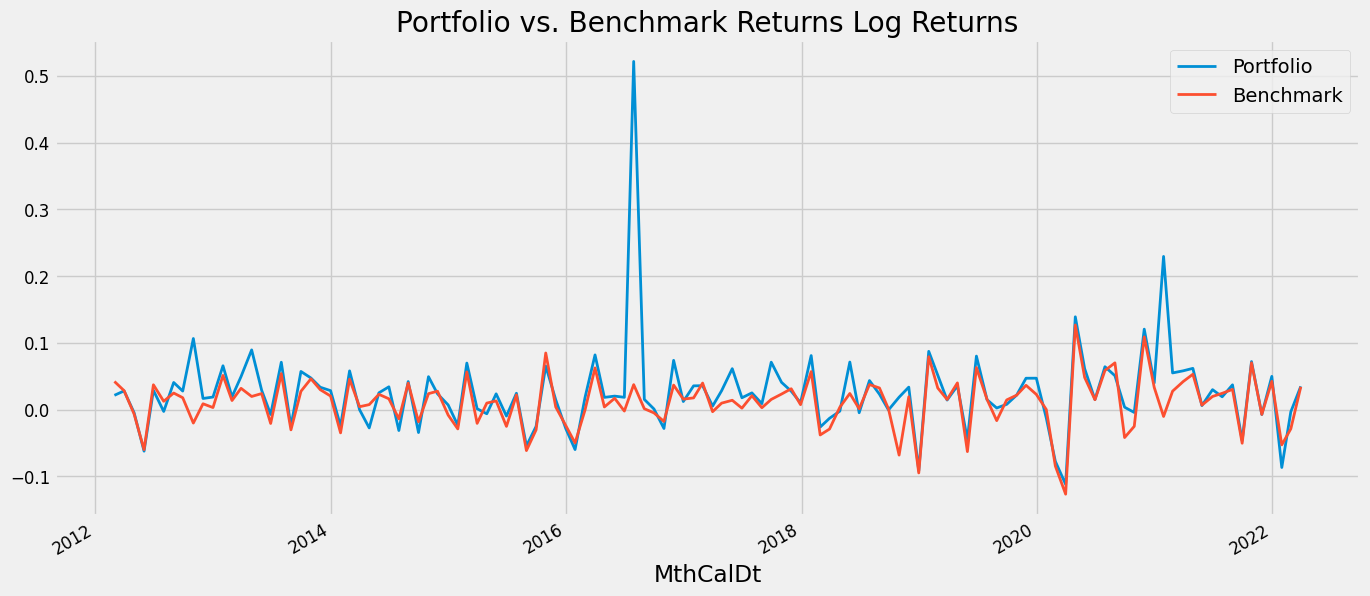

In [309]:
# Create a Line Plot of the portfolio_annual_returns and the benchmark_returns. X axis is the Index MthCalDt and Y axis is the returns
portfolio_annual_returns.plot(figsize=(15, 7), title='Portfolio vs. Benchmark Returns Log Returns', fontsize=12, linewidth=2.0)



In [310]:
benchmark_returns = pt_log['IVV']
# Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns = pd.DataFrame(benchmark_returns)  # Create Dataframe for benchmark_returns and the column name is Benchmark
benchmark_returns.columns = ['Benchmark']  # Rename the column name to Benchmark


# filter pt_retuns that matches tickers in sorted_brute_allocation index Ticker
filtered_pt_ret = pt_log[sorted_brute_allocation.index]

# Replace NaN with 0 in filtered_pt_ret
filtered_pt_ret2 = filtered_pt_ret.fillna(0)  

portfolio_annual_log_returns = np.dot(filtered_pt_ret2, sorted_brute_allocation['bruteAllocation']) # Portfolio returns

# Create Dataframe that matches the MthCalDt from pt_ret with the portfolio_annual_retuns
portfolio_annual_log_returns = pd.DataFrame(portfolio_annual_log_returns, index=pt_log.index, columns=['Portfolio'])

# Concatinate portfolio_annual_returns with benchmark_returns on the index MthCalDt
portfolio_annual_log_returns = pd.concat([portfolio_annual_log_returns, benchmark_returns], axis=1) 

# Make the index  MthCalDt a date time formate Year-Month-Day
portfolio_annual_log_returns.index = portfolio_annual_log_returns.index.astype(str)  
portfolio_annual_log_returns.index = pd.to_datetime(portfolio_annual_log_returns.index)  



portfolio_average_reteurn = portfolio_annual_log_returns["Portfolio"].mean()*12 # Portfolio Average Return
benchmark_average_return = portfolio_annual_log_returns["Benchmark"].mean()*12 # Benchmark Average Return
correlation_of_portfolio_and_benchmark_log = portfolio_annual_log_returns["Portfolio"].corr(portfolio_annual_log_returns["Benchmark"]) # Correlation of Portfolio and Benchmark

  # Benchmark Average Return

print(f"Average Portfolio Returns: {round(portfolio_average_reteurn,2)*100}%")  # Print the portfolio_annual_returns
print(f"Average Benchmark Returns: {round(benchmark_average_return,2)*100}%")  # Print the portfolio_average_reteurn
print(f"Correlation of Portfolio and Benchmark: {round(correlation_of_portfolio_and_benchmark_log,2)}")  # Print the correlation_of_portfolio_and_benchmark


portfolio_annual_log_returns


Average Portfolio Returns: 18.0%
Average Benchmark Returns: 12.0%
Correlation of Portfolio and Benchmark: 0.93


,Portfolio,Benchmark
MthCalDt,,
2012-02-29,0.019626,0.041256
2012-03-30,0.026714,0.027934
2012-04-30,-0.006604,-0.006608
2012-05-31,-0.066610,-0.061976
2012-06-29,0.026741,0.036490
...,...,...
2021-11-30,-0.009856,-0.007315
2021-12-31,0.046219,0.041435
2022-01-31,-0.094492,-0.054322


<AxesSubplot: title={'center': 'Portfolio vs. Benchmark Returns Log Returns'}, xlabel='MthCalDt'>

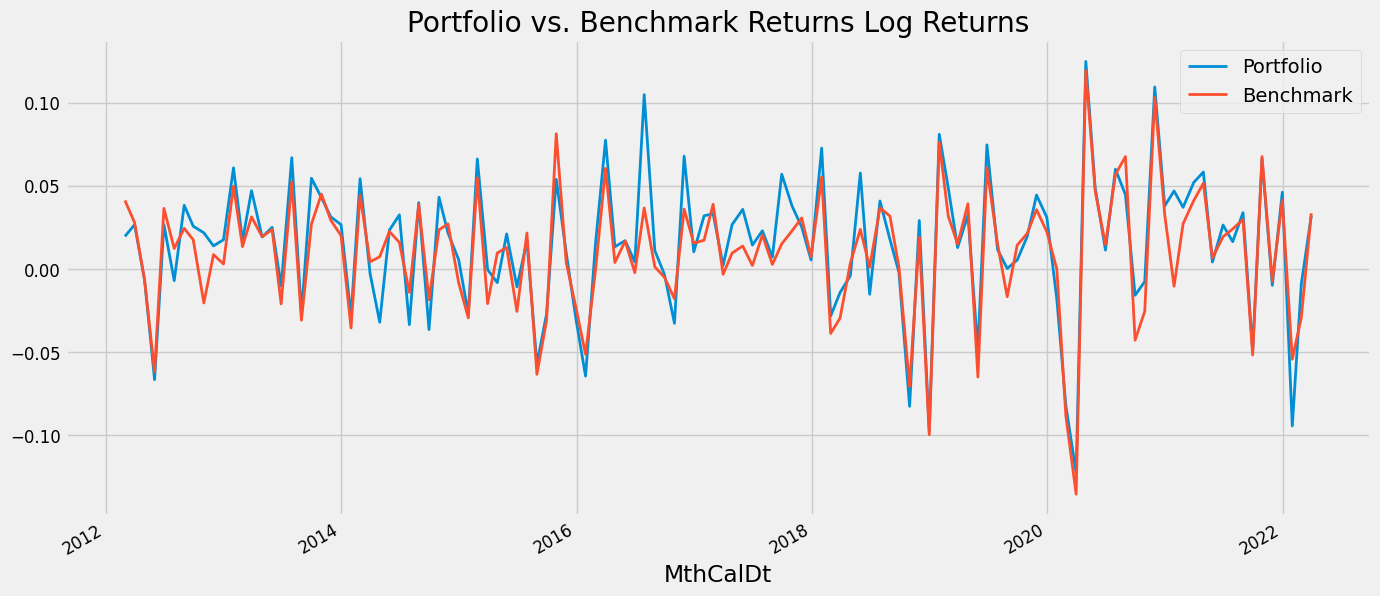

In [311]:
# Log Returns
portfolio_annual_log_returns.plot(figsize=(15, 7), title='Portfolio vs. Benchmark Returns Log Returns', fontsize=12, linewidth=2.0)
